In [1]:
## Visualize the trained model

import sys
#sys.path.append('deps/sparse_rrt')
sys.path.append('.')
import torch
import torch.nn as nn
import importlib
#from model import ae_s2d
#from model import cvae_s2d_model1 as cvae_s2d

from model.SMPNet import SMPNet
#from tools import data_loader
from tools.utility import *
#from plan_utility import cart_pole, cart_pole_obs, pendulum, acrobot_obs, car_obs
import argparse
import numpy as np
import random
import os
from tqdm import tqdm, trange


In [2]:
parser = argparse.ArgumentParser()
# for training
parser.add_argument('--model_dir', type=str, default='/ilab/users/ym420/Documents/ylmiao/results/SMPNet/',help='path for saving trained models')
parser.add_argument('--no_env', type=int, default=10,help='directory for obstacle images')
parser.add_argument('--no_motion_paths', type=int,default=200,help='number of optimal paths in each environment')
parser.add_argument('--s', type=int, default=0,help='directory for obstacle images')
parser.add_argument('--sp', type=int,default=4000,help='number of optimal paths in each environment')

# Model parameters
parser.add_argument('--e_net_input_size', type=int, default=32, help='dimension of environment encoding network input')
parser.add_argument('--e_net_output_size', type=int, default=28, help='dimension of environment encoding network output')
parser.add_argument('--model_id', type=int, default=0, help='id of the model that we are using')

parser.add_argument('--input_size', type=int, default=2, help='dimension of input to be reconstructed')
parser.add_argument('--latent_size', type=int, default=2, help='dimension of latent variable')
parser.add_argument('--cond_size', type=int, default=32, help='dimension of condition variable (start, goal, environment encoding)')

parser.add_argument('--learning_rate', type=float, default=0.01)
parser.add_argument('--beta', type=float, default=1.0, help='scale the KL divergence loss relative to reconstruction loss')

parser.add_argument('--lr_schedule_gamma', type=float, default=0.9)
parser.add_argument('--lr_schedule_patience', type=int, default=2)

parser.add_argument('--device', type=int, default=2, help='cuda device')

parser.add_argument('--data_folder', type=str, default='/freespace/local/ym420/course/cse535/data/')

parser.add_argument('--start_epoch', type=int, default=54)
parser.add_argument('--env_type', type=str, default='s2d', help='environment')
parser.add_argument('--world_size', nargs='+', type=float, default=[20.0, 20.0], help='boundary of world')
parser.add_argument('--opt', type=str, default='Adagrad')

args = parser.parse_args("")


In [3]:
if torch.cuda.is_available():
    torch.cuda.set_device(args.device)
# environment setting
cae = None
mlp = None

# load net
# load previously trained model if start epoch > 0

# dynamically import model
ae_module = importlib.import_module('model.ae_%s_model_%d' % (args.env_type, args.model_id))
cvae_module = importlib.import_module('model.cvae_%s_model_%d' % (args.env_type, args.model_id))
e_net = ae_module.Encoder(input_size=args.e_net_input_size, output_size=args.e_net_output_size)
cvae = cvae_module.CVAE(input_size=args.input_size, latent_size=args.latent_size, cond_size=args.cond_size)

data_loader = importlib.import_module('tools.data_loader_%s' % (args.env_type))
plan_util = importlib.import_module('plan_util.%s' % (args.env_type))
normalize = plan_util.normalize
unnormalize = plan_util.unnormalize

smpnet = SMPNet(e_net, cvae)
model_dir = args.model_dir + "%s/model_%d/lr_%f_lrgamma_%f_lrpatience_%d_opt_%s_beta_%f/" % \
                            (args.env_type, args.model_id, args.learning_rate, \
                             args.lr_schedule_gamma, args.lr_schedule_patience, args.opt, args.beta)
if not os.path.exists(model_dir):
    os.makedirs(model_dir, exist_ok=True)
model_path='smpnet_epoch_%d.pkl' %(args.start_epoch)
torch_seed, np_seed, py_seed = 0, 0, 0
if args.start_epoch > 0:
    load_net_state(smpnet, os.path.join(model_dir, model_path))
    torch_seed, np_seed, py_seed = load_seed(os.path.join(model_dir, model_path))
    # set seed after loading
    torch.manual_seed(torch_seed)
    np.random.seed(np_seed)
    random.seed(py_seed)

if torch.cuda.is_available():
    smpnet.cuda()
    smpnet.cvae.cuda()
    smpnet.e_net.cuda()
    if args.opt == 'Adagrad':
        smpnet.set_opt(torch.optim.Adagrad, lr=args.learning_rate)
    elif args.opt == 'Adam':
        smpnet.set_opt(torch.optim.Adam, lr=args.learning_rate)
    elif args.opt == 'SGD':
        smpnet.set_opt(torch.optim.SGD, lr=args.learning_rate, momentum=0.9)
    elif args.opt == 'ASGD':
        smpnet.set_opt(torch.optim.ASGD, lr=args.learning_rate)
if args.start_epoch > 0:
    load_opt_state(smpnet, os.path.join(model_dir, model_path))
data_folder = args.data_folder+args.env_type+'/'


length of the output of one encoder
343


In [4]:
# test to see the error
waypoint_dataset, start_dataset, goal_dataset, obs, start_indices, goal_indices, env_indices \
         = data_loader.load_train_dataset(N=10, NP=200,
                                            data_folder=data_folder)
start_dataset, goal_dataset = np.array(start_dataset), np.array(goal_dataset)

# randomize the dataset before training
data=list(zip(waypoint_dataset, start_indices, goal_indices, env_indices))
random.shuffle(data)
waypoint_dataset,start_indices,goal_indices,env_indices=list(zip(*data))
waypoint_dataset = list(waypoint_dataset)
start_indices = list(start_indices)
goal_indices = list(goal_indices)
env_indices = list(env_indices)
waypoint_dataset = np.array(waypoint_dataset)
start_indices, goal_indices, env_indices = np.array(start_indices), np.array(goal_indices), np.array(env_indices)

smpnet.train()
epoch_val_num = 2048
waypoint_dataset_i = waypoint_dataset[:epoch_val_num]
start_indices_i, goal_indices_i, env_indices_i = start_indices[:epoch_val_num], \
                                                goal_indices[:epoch_val_num], \
                                                env_indices[:epoch_val_num]
bi = waypoint_dataset_i
bi = torch.FloatTensor(bi)
bi = normalize(bi, args.world_size)
bi=to_var(bi)
y_start_i = start_dataset[start_indices_i]
y_goal_i = goal_dataset[goal_indices_i]
y_start_i, y_goal_i = torch.FloatTensor(y_start_i), torch.FloatTensor(y_goal_i)
y_start_i, y_goal_i = normalize(y_start_i, args.world_size), normalize(y_goal_i, args.world_size)
y_start_i, y_goal_i = to_var(y_start_i), to_var(y_goal_i)
bobs = obs[env_indices_i].astype(np.float32)
bobs = torch.FloatTensor(bobs)
bobs = to_var(bobs)
loss = smpnet.loss(bi, smpnet.train_forward(bi, y_start_i, y_goal_i, bobs), beta=args.beta)
loss = torch.mean(loss)
print('mean loss: %f' % (loss.cpu().item()))



mean loss: 37.064095


In [5]:
# load test data
print('loading...')
obs_center, obs, paths, path_lengths = \
        data_loader.load_test_dataset(N=args.no_env, NP=args.no_motion_paths, \
                                      s=args.s, sp=args.sp, folder=data_folder)
obs_width = 5.


loading...


In [6]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def cvae_visualization(smpnet, obs_idx, path_idx, num_sample=10):
    # visualize the planning scene and samples
    obs_center_i = obs_center[obs_idx]
    obs_i = obs[obs_idx]
    path_i = paths[obs_idx][path_idx]
    path_length_i = path_lengths[obs_idx][path_idx]
    #print(path_length_i)
    assert path_length_i > 2
    y_start_i = path_i[0]
    y_goal_i = path_i[path_length_i-1]
    y_start_i, y_goal_i = torch.FloatTensor(y_start_i).unsqueeze(0), torch.FloatTensor(y_goal_i).unsqueeze(0)
    y_start_i, y_goal_i = y_start_i.repeat(num_sample,1), y_goal_i.repeat(num_sample,1)
    y_start_i, y_goal_i = normalize(y_start_i, args.world_size), normalize(y_goal_i, args.world_size)
    y_start_i, y_goal_i = to_var(y_start_i), to_var(y_goal_i)
    
    #print([num_sample]+list(obs_i.shape))
    bobs = torch.FloatTensor(obs_i).unsqueeze(0).repeat([num_sample, 1, 1, 1])
    bobs = to_var(bobs)
    #print(bobs.size())
    # generating
    samples = smpnet.gen_forward(y_start_i, y_goal_i, obs=bobs, obs_z=None)
    samples = samples.cpu().data
    samples = unnormalize(samples, args.world_size).numpy()
    
    # visualize
    # show obstacles
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.set_xlim(-22, 22)
    ax.set_ylim(-22, 22)
    #print(obs_center_i.shape)

    for i in range(len(obs_center_i)):
        x, y = obs_center_i[i][0], obs_center_i[i][1]
        obs_patch_i = patches.Rectangle((x-obs_width/2,y-obs_width/2),\
                                       obs_width,obs_width,\
                                       linewidth=0.0, facecolor='black')
        ax.add_patch(obs_patch_i)
    
    # show start and goal
    ax.scatter([path_i[0][0]], [path_i[0][1]], c='green', s=100.0)
    ax.scatter([path_i[path_length_i-1][0]], [path_i[path_length_i-1][1]], c='red', s=100.0, marker='*')
    
    # show samples
    ax.scatter(samples[:,0], samples[:,1], c='blue', s=50.)
    return fig

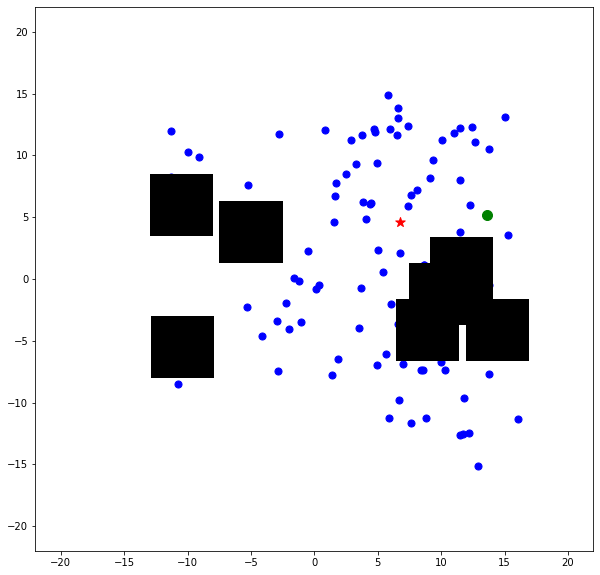

In [7]:
fig = cvae_visualization(smpnet, 0, 0, num_sample=100)
plt.show()


In [8]:
print(path_lengths)

[[ 3  5  9 ... 12  6  2]
 [14  6  9 ...  2  4 22]
 [ 2 17  6 ...  4 11  7]
 ...
 [ 9 16  4 ...  4  4  3]
 [ 4  3 20 ...  5 20  3]
 [14  9  8 ...  2  2  9]]


 38%|███▊      | 20/53 [00:03<00:05,  5.82it/s]<ipython-input-6-3c80c93aa1a7>:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(10,10))
100%|██████████| 53/53 [00:09<00:00,  5.77it/s]


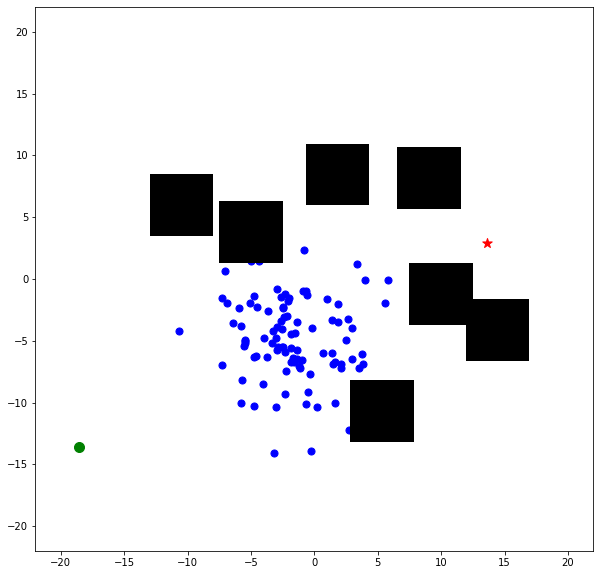

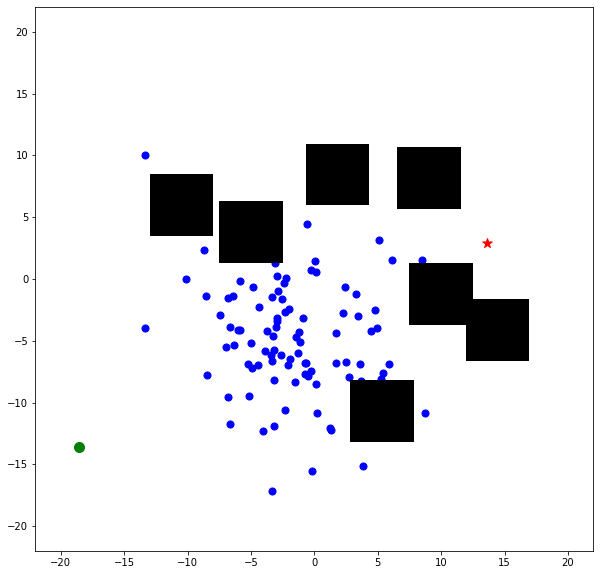

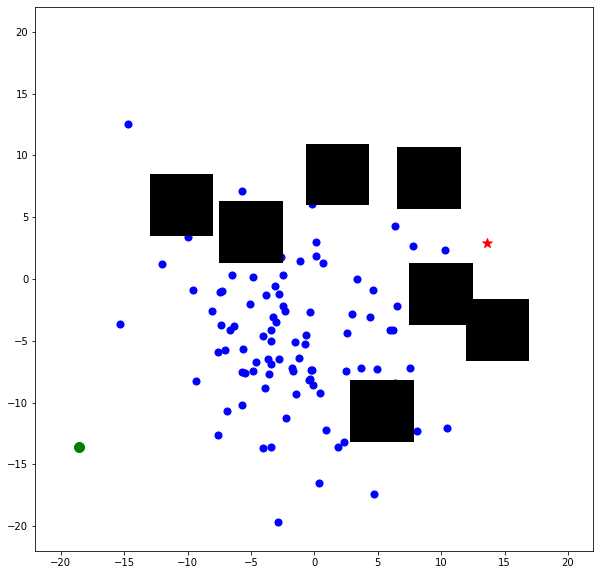

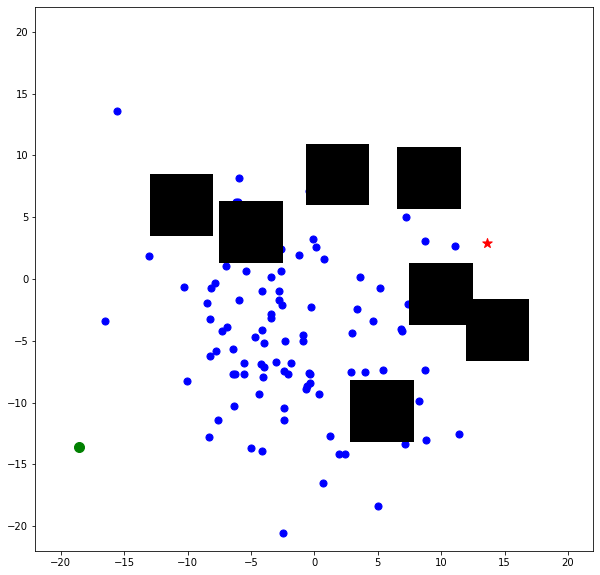

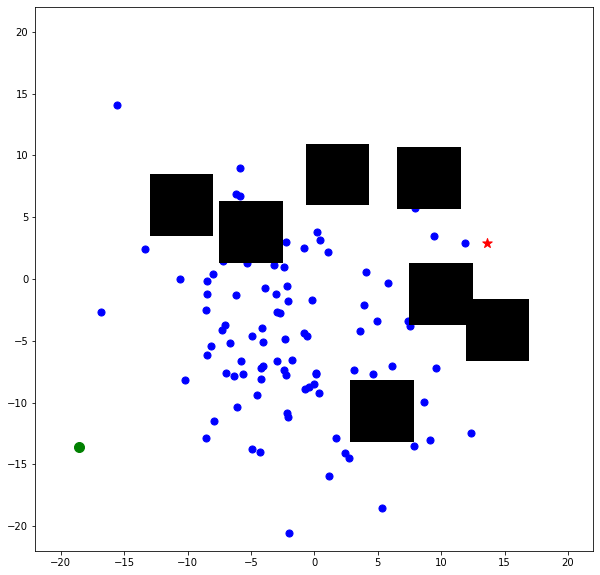

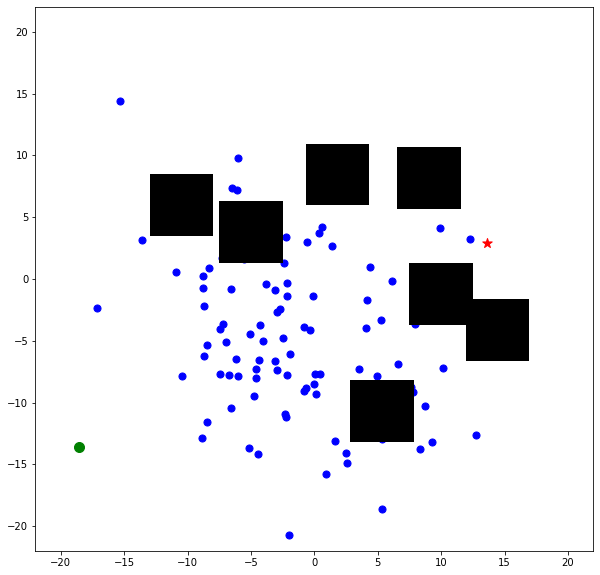

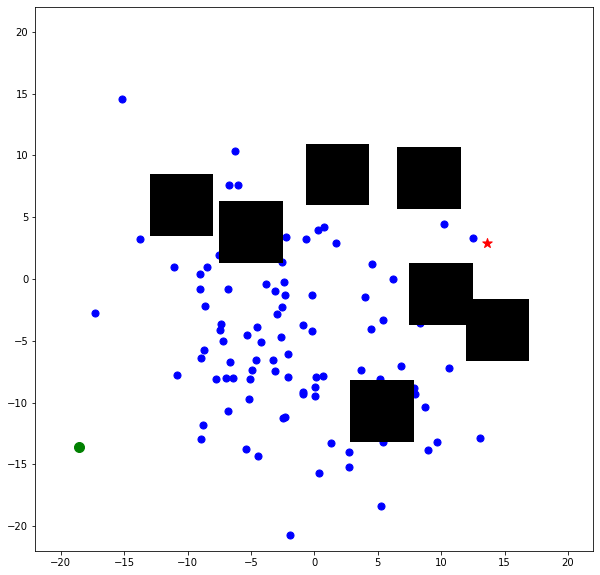

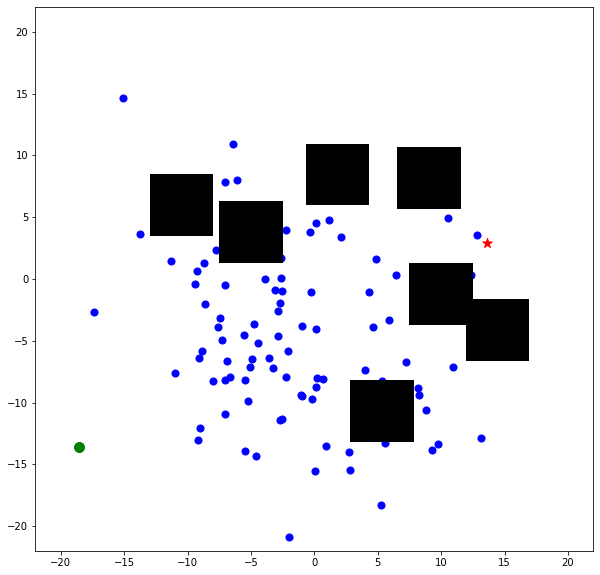

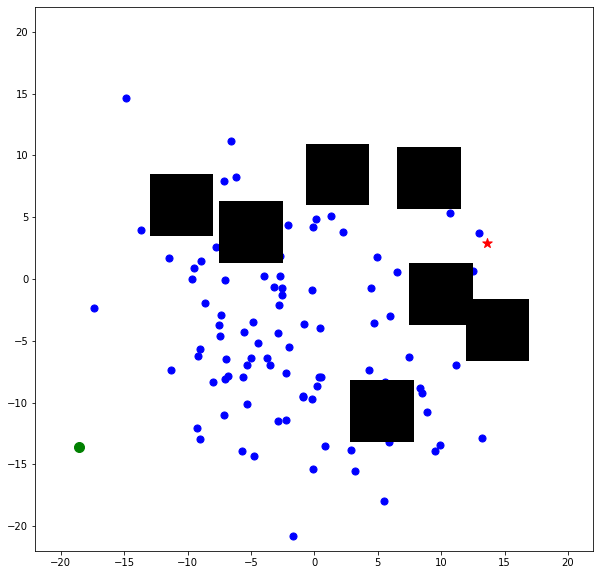

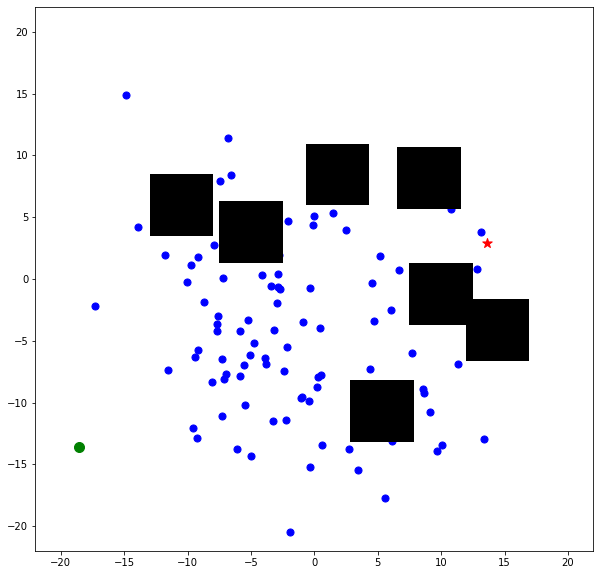

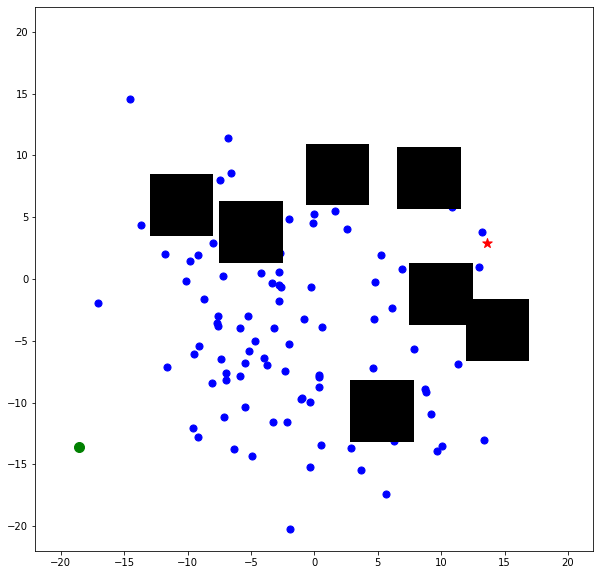

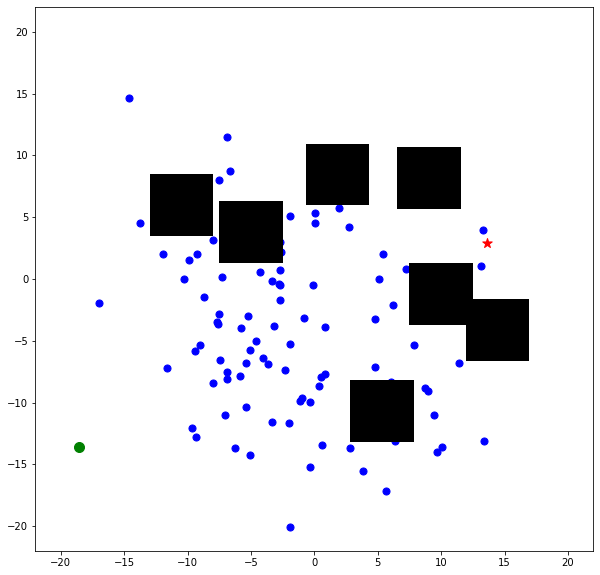

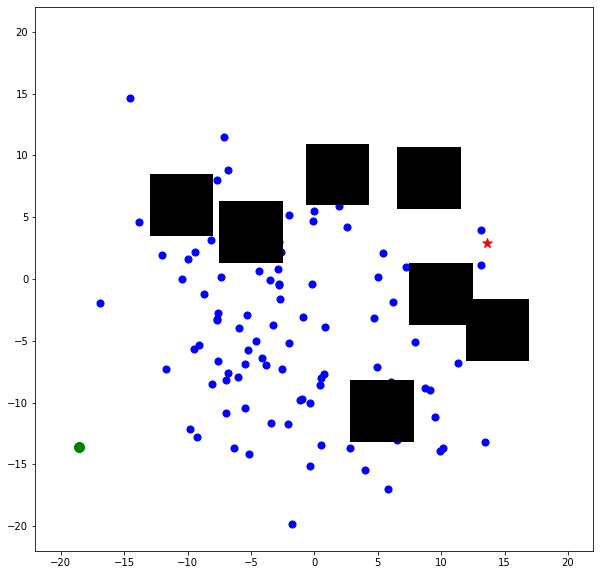

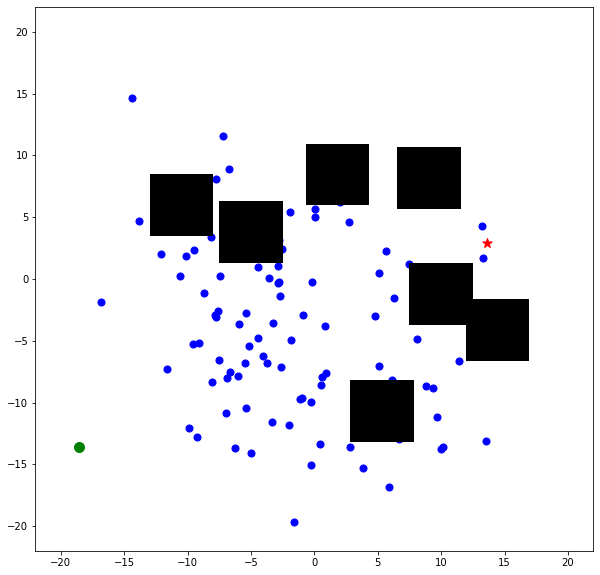

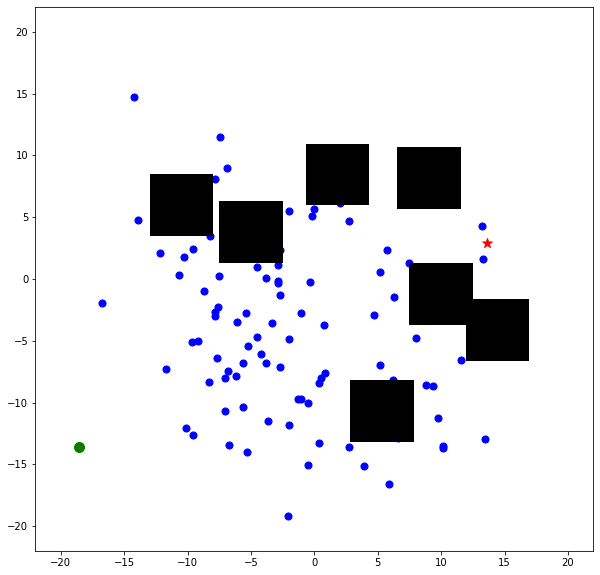

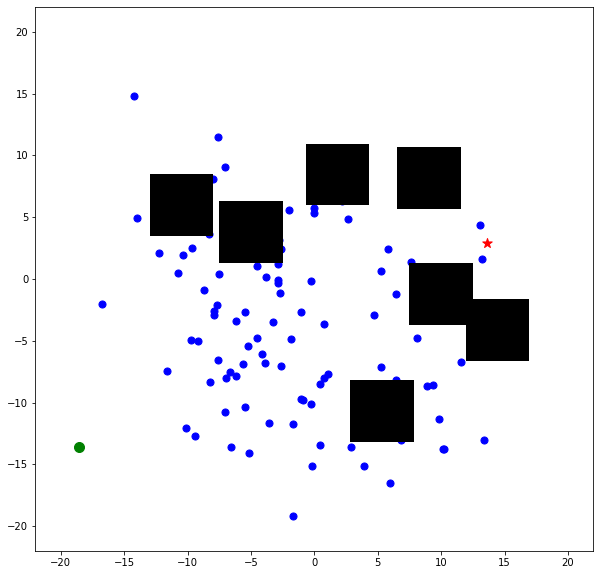

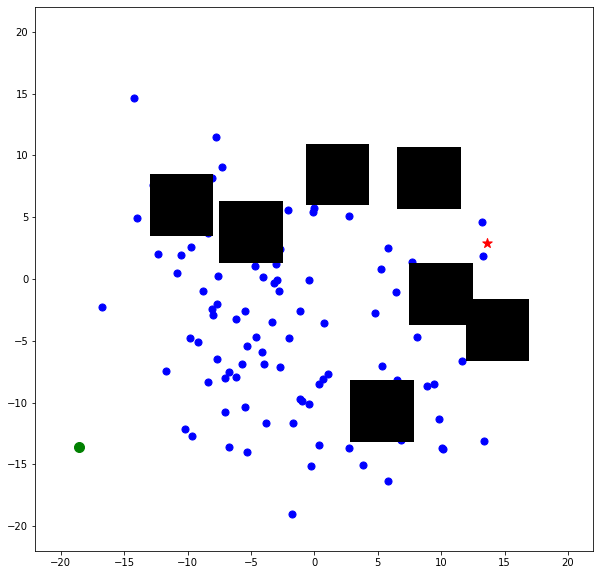

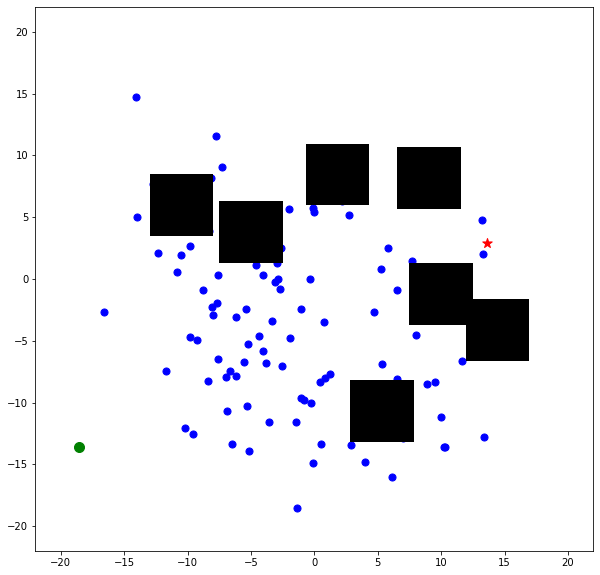

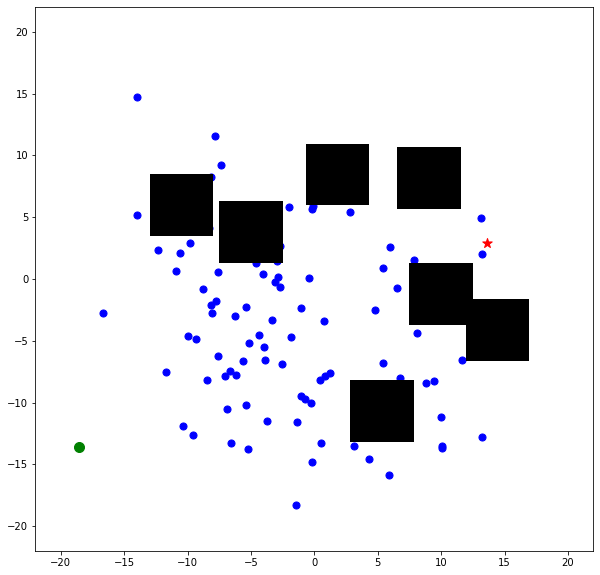

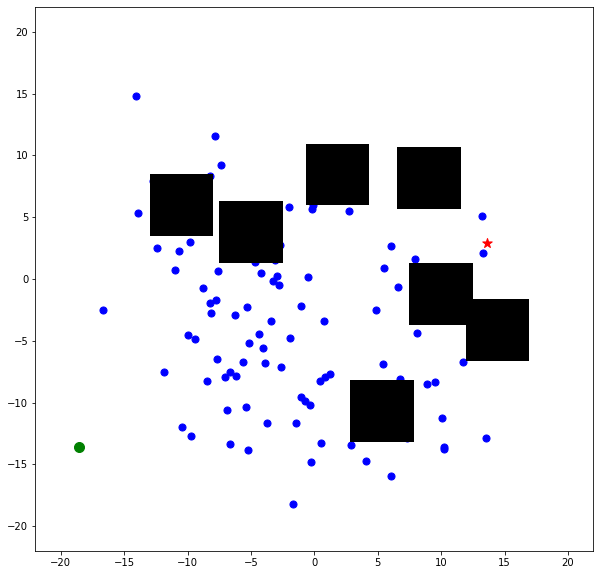

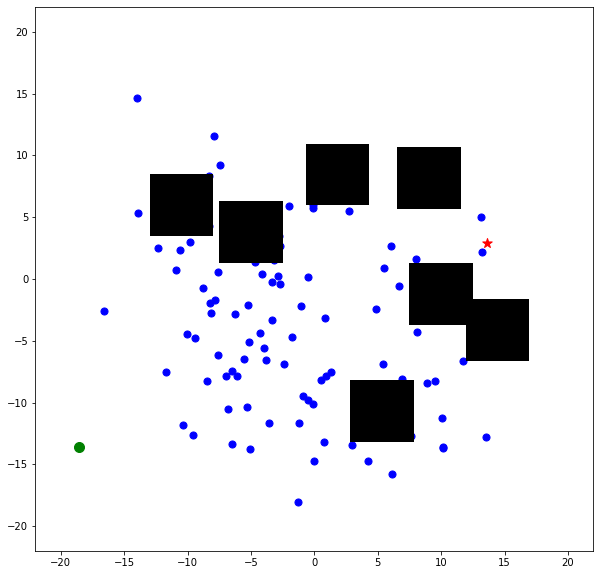

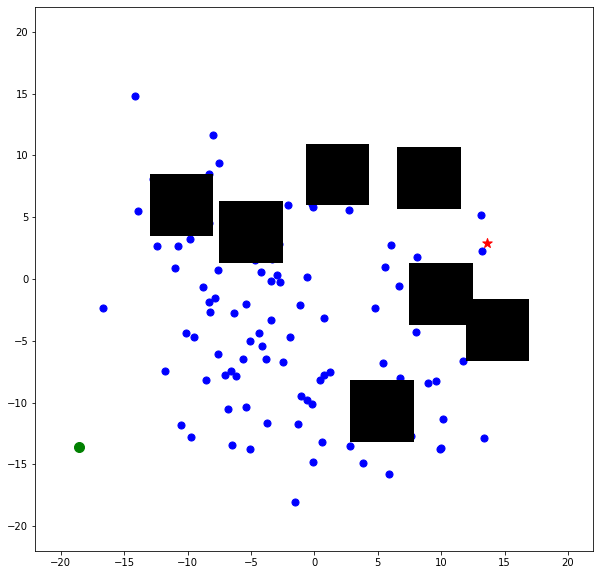

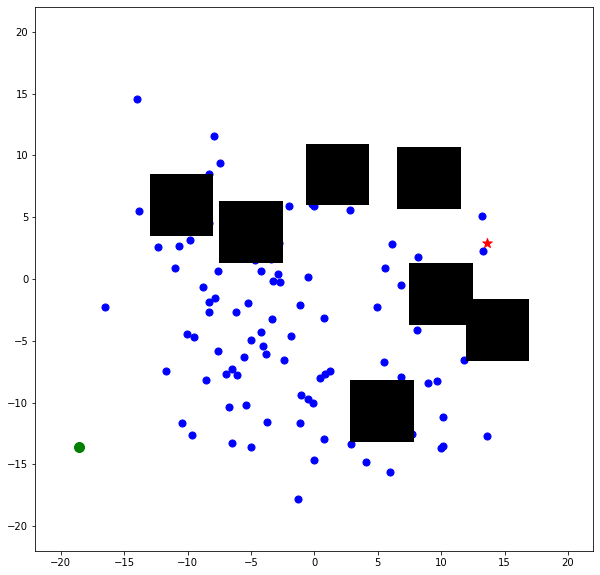

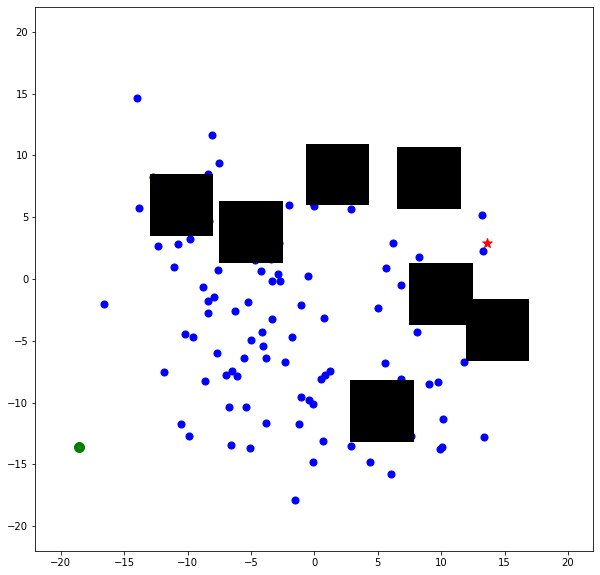

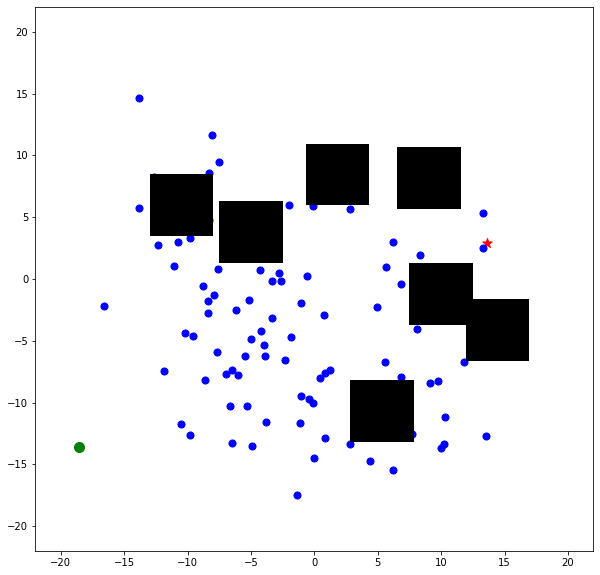

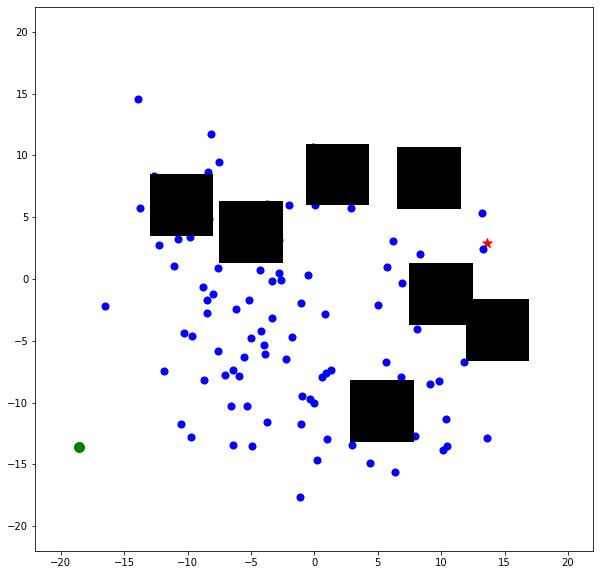

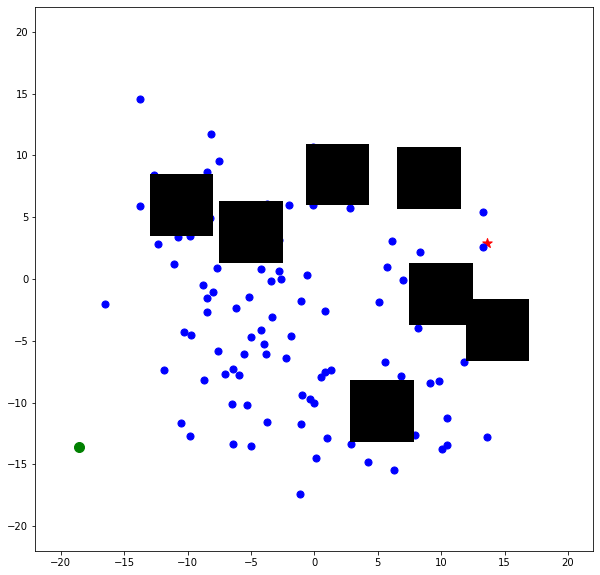

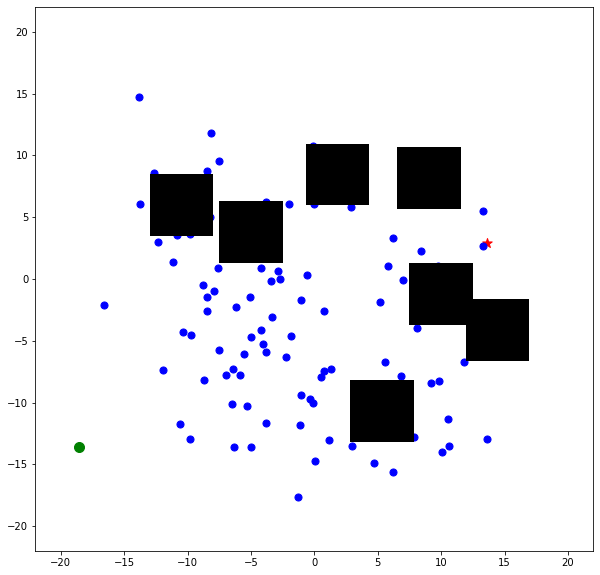

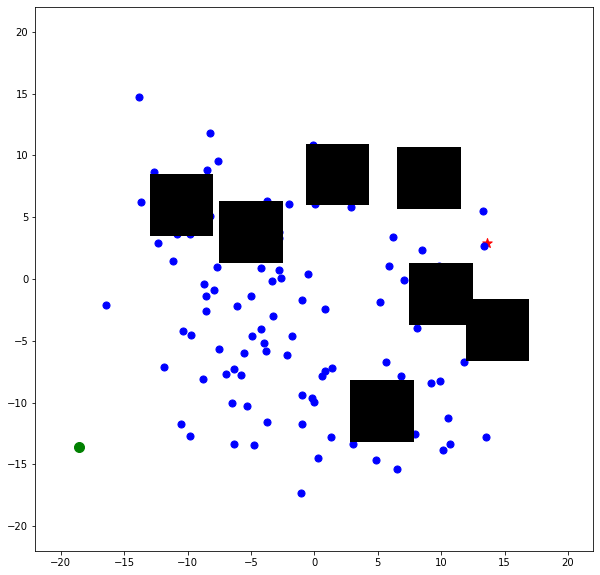

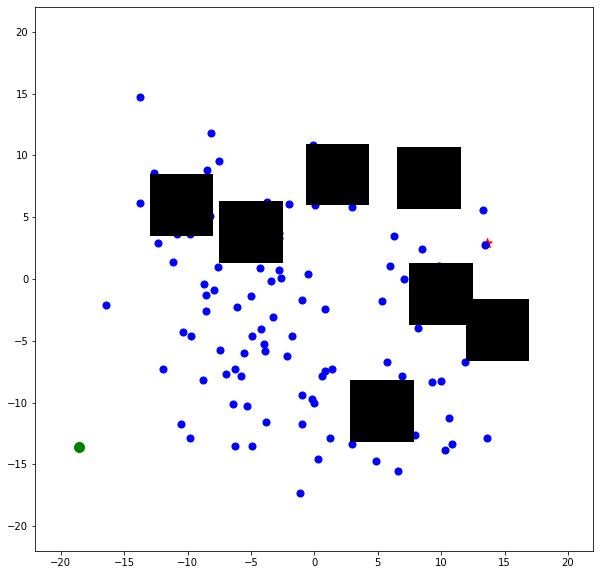

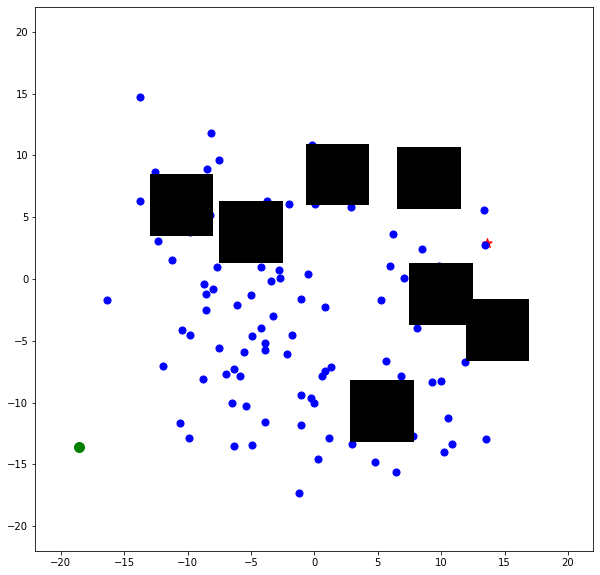

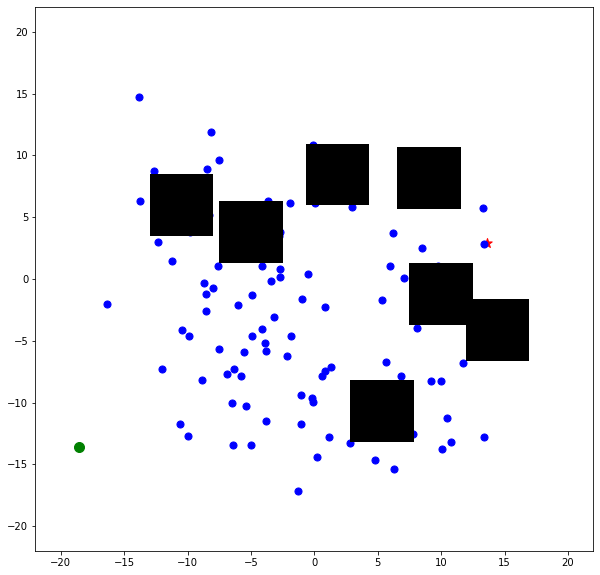

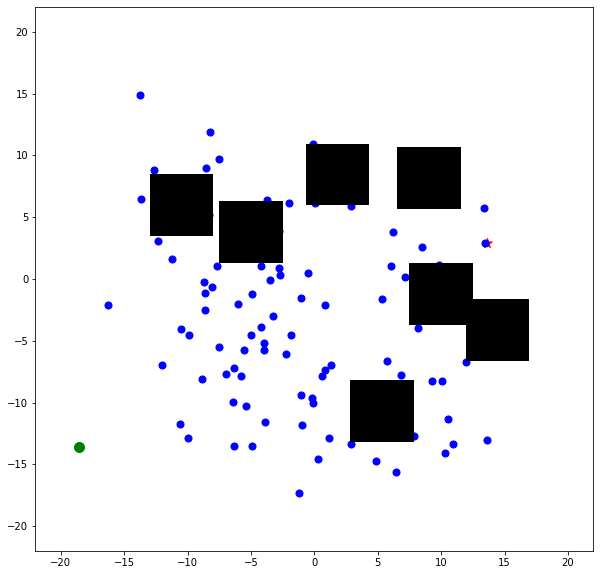

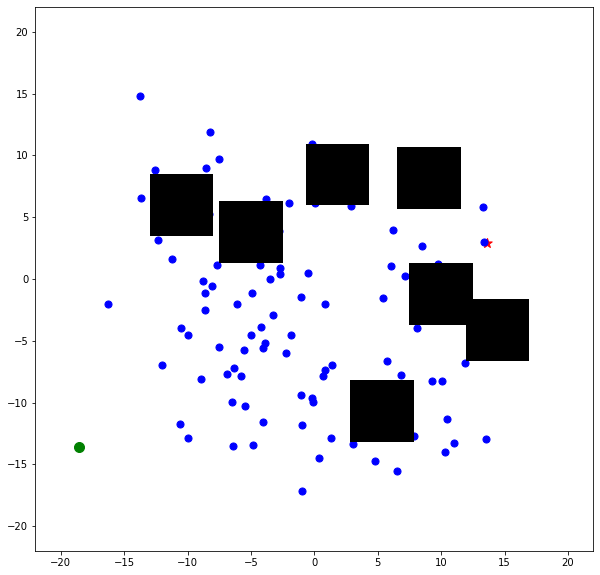

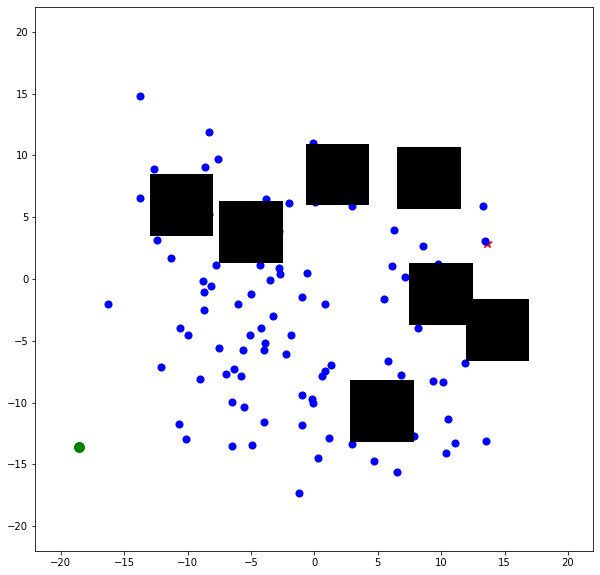

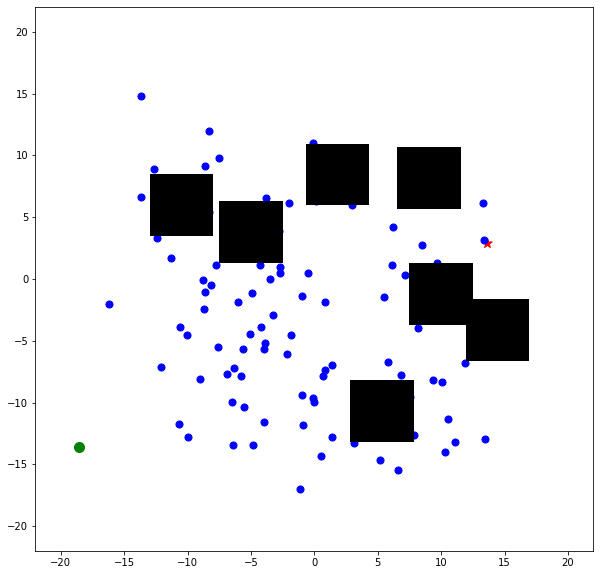

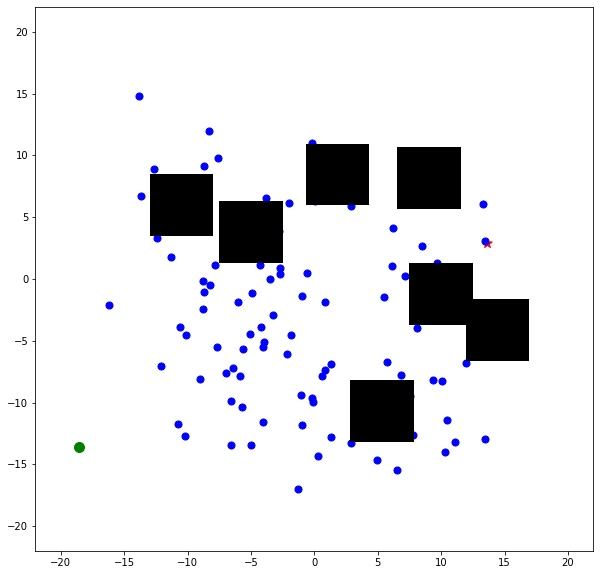

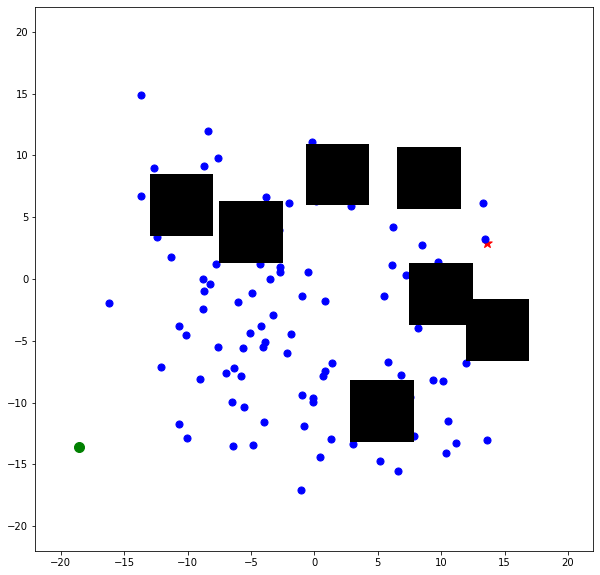

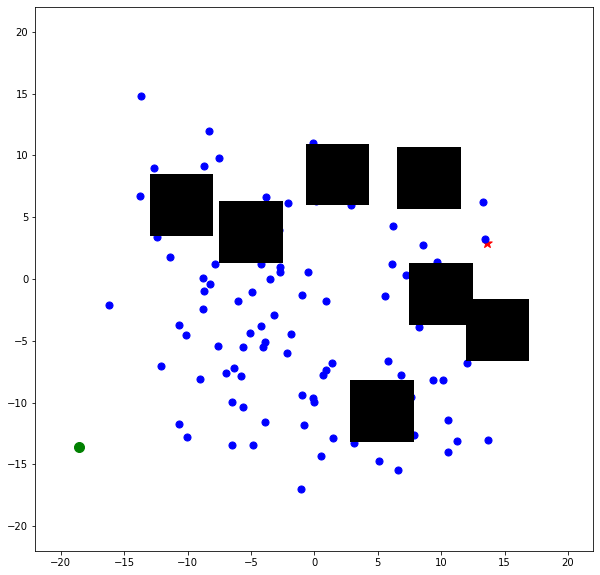

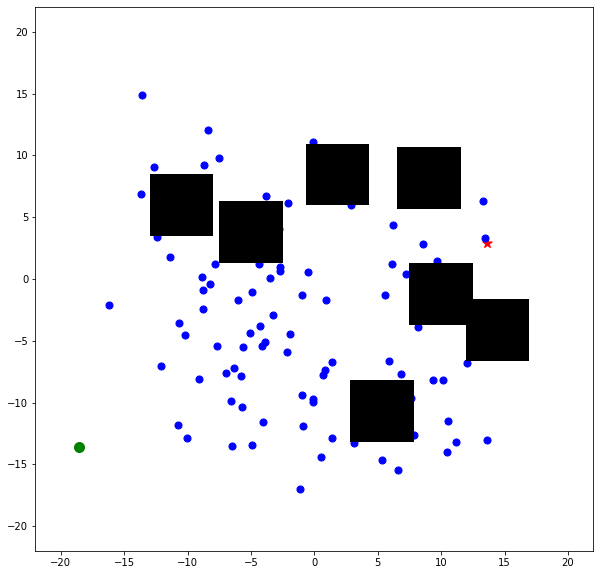

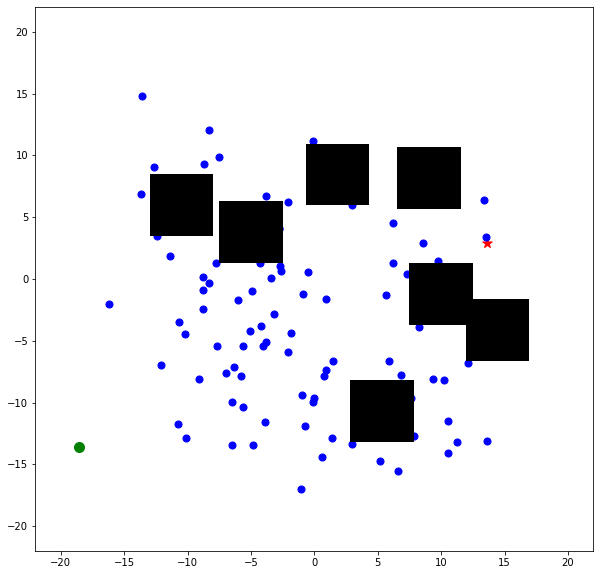

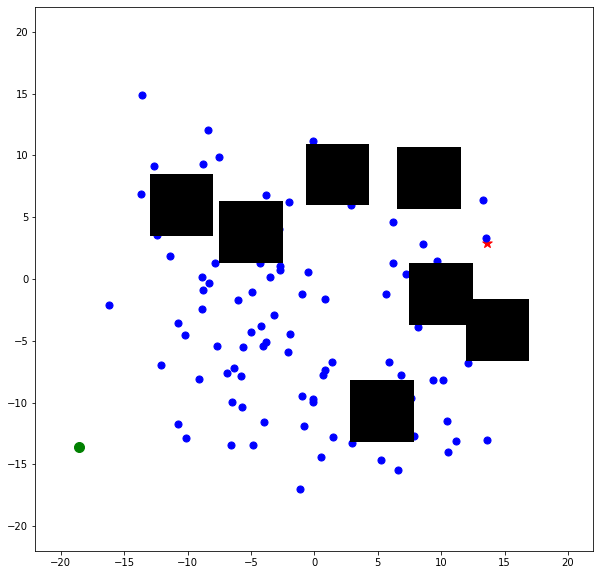

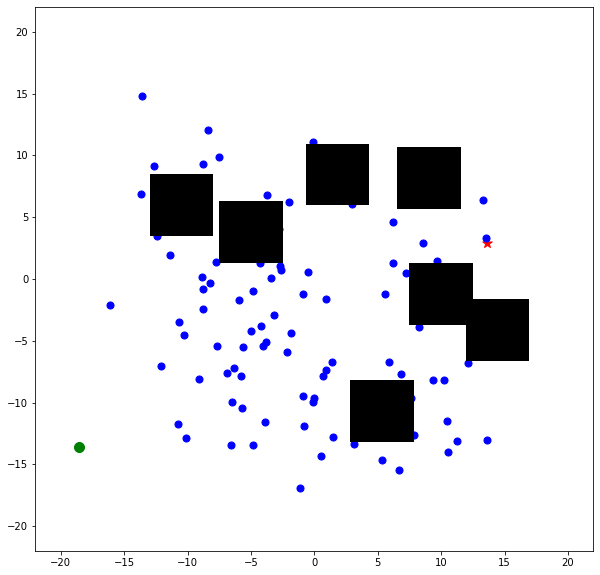

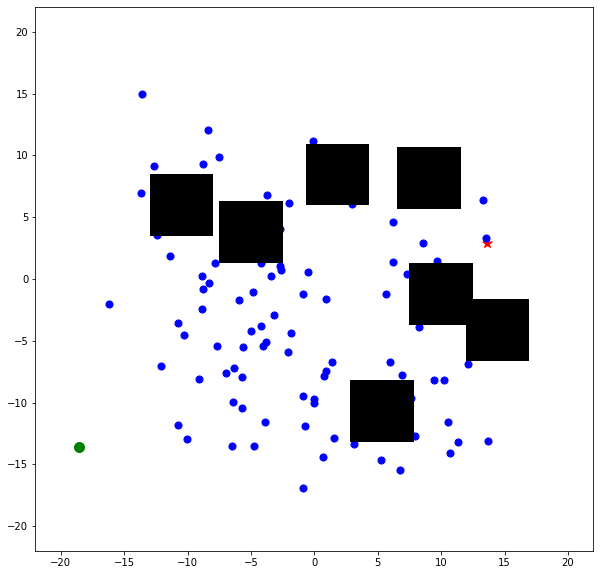

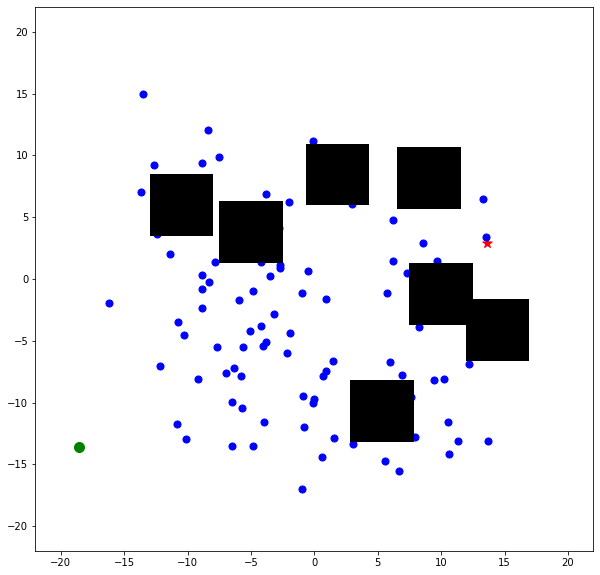

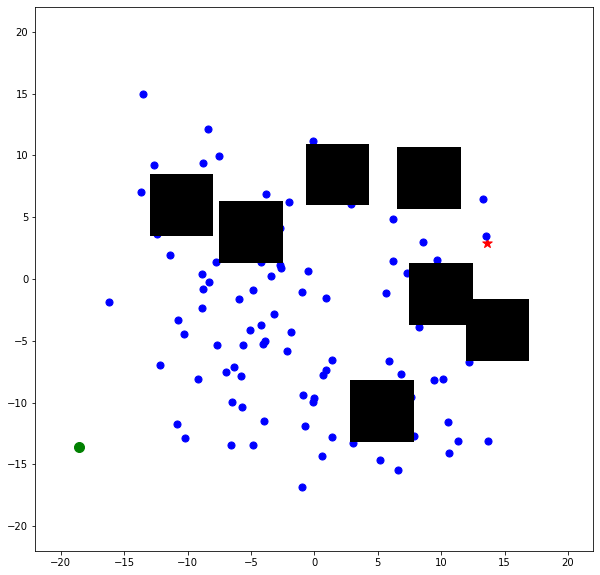

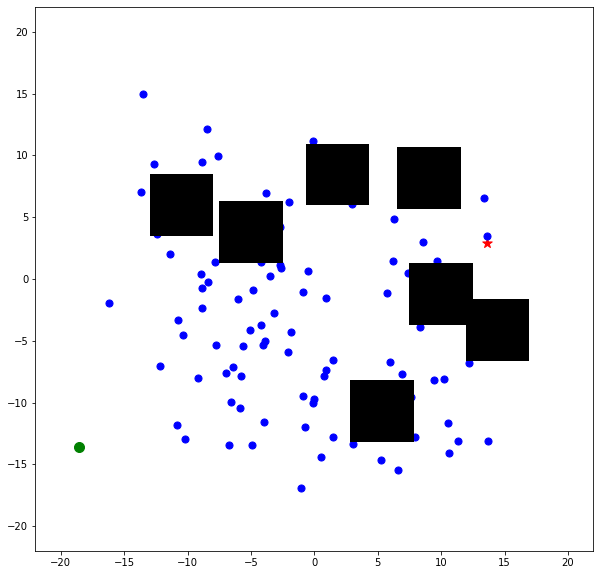

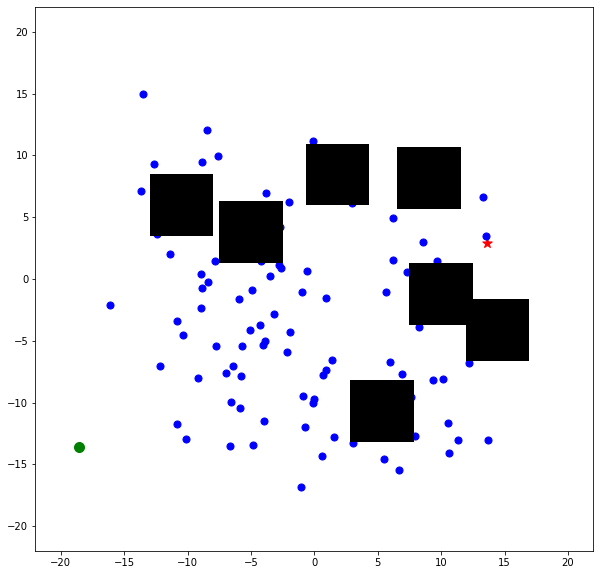

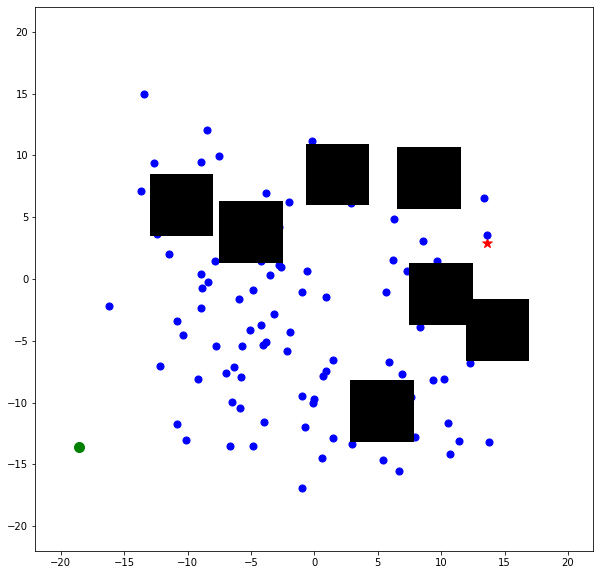

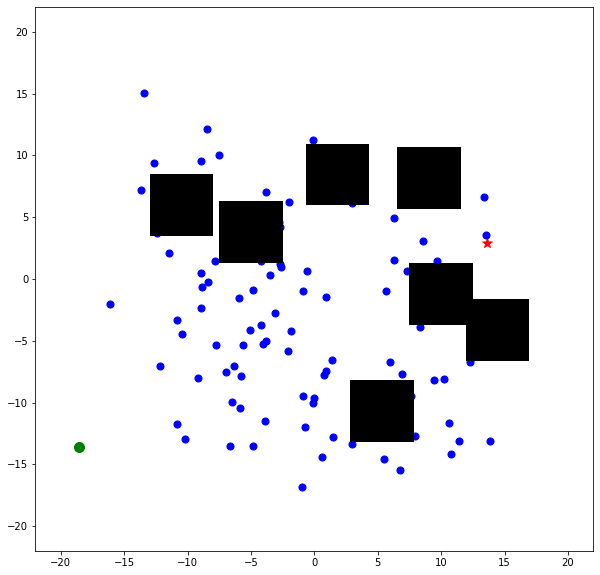

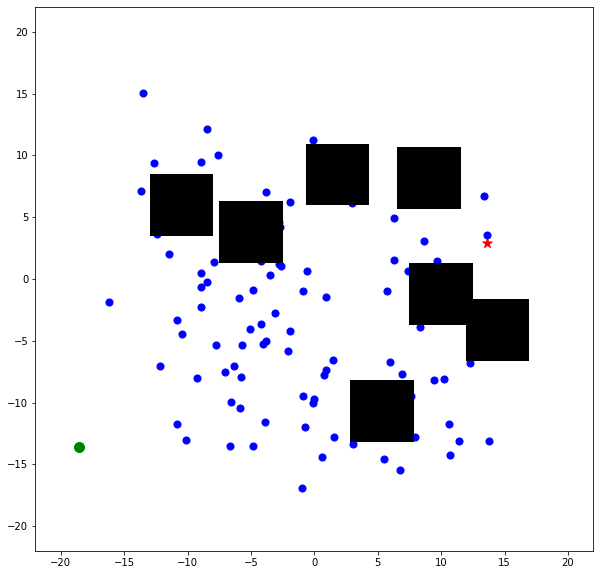

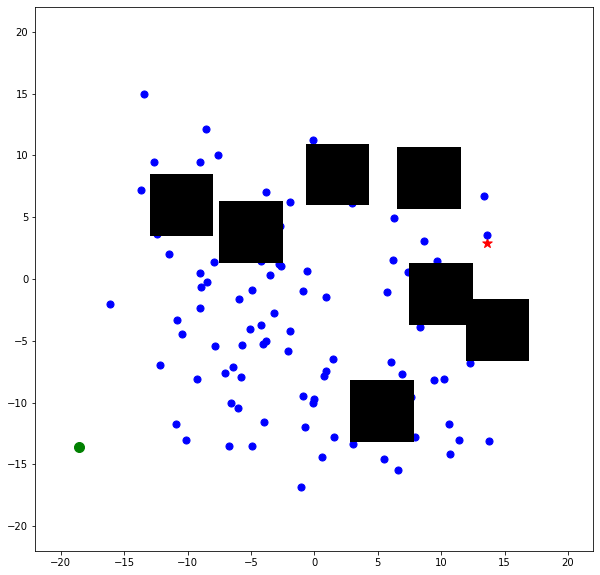

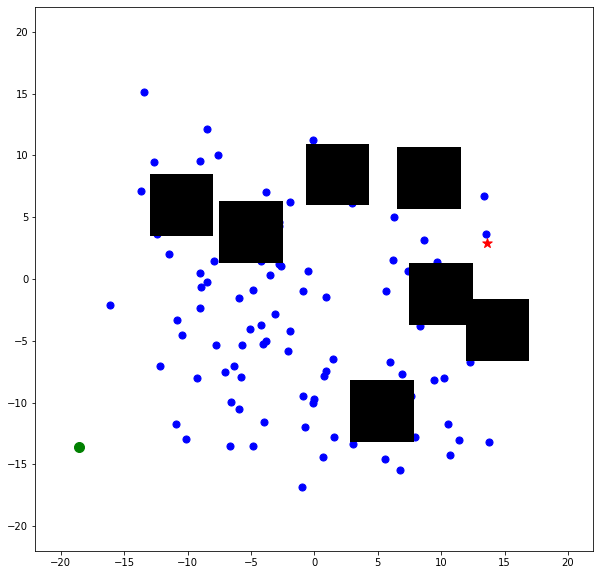

In [9]:
# save figure for different model
obs_idx = 1
path_idx = 100
for epoch_i in trange(1,args.start_epoch):
    if args.start_epoch > 0:
        smpnet = SMPNet(e_net, cvae)
        model_path='smpnet_epoch_%d.pkl' %(epoch_i)
        load_net_state(smpnet, os.path.join(model_dir, model_path))
        torch_seed, np_seed, py_seed = load_seed(os.path.join(model_dir, model_path))
        # set seed after loading
        torch.manual_seed(torch_seed)
        np.random.seed(np_seed)
        random.seed(py_seed)

        if torch.cuda.is_available():
            smpnet.cuda()
            smpnet.cvae.cuda()
            smpnet.e_net.cuda()

        fig = cvae_visualization(smpnet, obs_idx, path_idx, num_sample=100);
        plt.savefig("plots/env_%d_path_%d_epoch_%d.png" % (obs_idx+args.s, path_idx+args.sp, epoch_i));

In [10]:
!pip install imageio

In [11]:
import imageio
def make_video(obs_idx, path_idx):
    def tryint(s):
        try:
            return int(s)
        except ValueError:
            return s
    def str2int(v_str):
        idx = v_str.split('epoch_')[1]
        idx = int(idx[:-4])
        return idx
    def sort_humanly(v_list):
        return sorted(v_list, key=str2int)
    image_folder = 'plots'
    video_name = 'video/env_{}_{}.gif'.format(obs_idx, path_idx)
    images = [img for img in os.listdir(image_folder) if 'env_%d_path_%d' % (obs_idx, path_idx) in img]
    images = sort_humanly(images)
    imgs = []
    for filename in images:
#         print('./'+image_folder+'/'+filename)
        imgs.append(imageio.imread('./'+image_folder+'/'+filename))
    imageio.mimsave(video_name, imgs)

In [12]:
make_video(obs_idx+args.s, path_idx+args.sp)